# Описание проекта

## Загрузить даные и подготовить к анализу 

In [1]:
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

изучили типы данных: необходимо преобразовать данные с датой и временем в нужный тип

In [3]:
visits['Start Ts'] = pd.to_datetime(
    visits['Start Ts'], format="%Y-%m-%d %H:%M"
)
visits['End Ts'] = pd.to_datetime(
    visits['End Ts'], format="%Y-%m-%d %H:%M"
)
orders['Buy Ts'] = pd.to_datetime(
    orders['Buy Ts'], format="%Y-%m-%d %H:%M"
)
costs['dt'] = pd.to_datetime(costs['dt'])

## Рассчет метрик и графики

### Продуктовые метрики

выделим в отдельные столбцы год, месяц и неделю, а также полную дату.

In [4]:
visits['session_year']  = visits['Start Ts'].dt.year
visits['session_month'] = visits['Start Ts'].astype('datetime64[M]')
visits['session_week']  = visits['Start Ts'].astype('datetime64[W]')
visits['session_date']  = visits['Start Ts'].dt.date

**Посчитаем метрики DAU, WAU, MAU**

In [5]:
dau = visits.groupby('session_date').agg({'Uid': 'nunique'})
wau = visits.groupby('session_week').agg({'Uid': 'nunique'})
mau = visits.groupby('session_month').agg({'Uid': 'nunique'})

print(dau.mean())
print(wau.mean())
print(mau.mean())

Uid    907.991758
dtype: float64
Uid    5724.415094
dtype: float64
Uid    23228.416667
dtype: float64


построим графики изменений метрик во времени

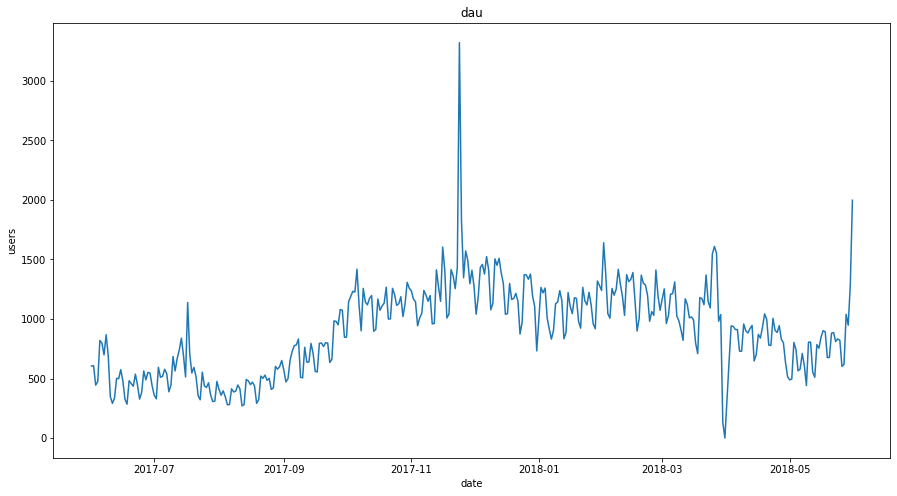

In [6]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(dau)
ax.set(title = 'dau', xlabel = 'date', ylabel = 'users')

plt.show()

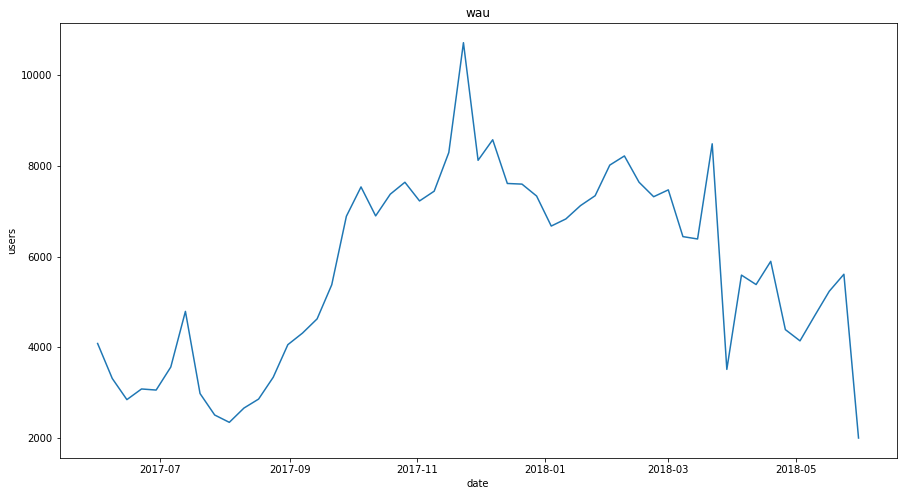

In [7]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(wau)
ax.set(title = 'wau', xlabel = 'date', ylabel = 'users')
plt.show()

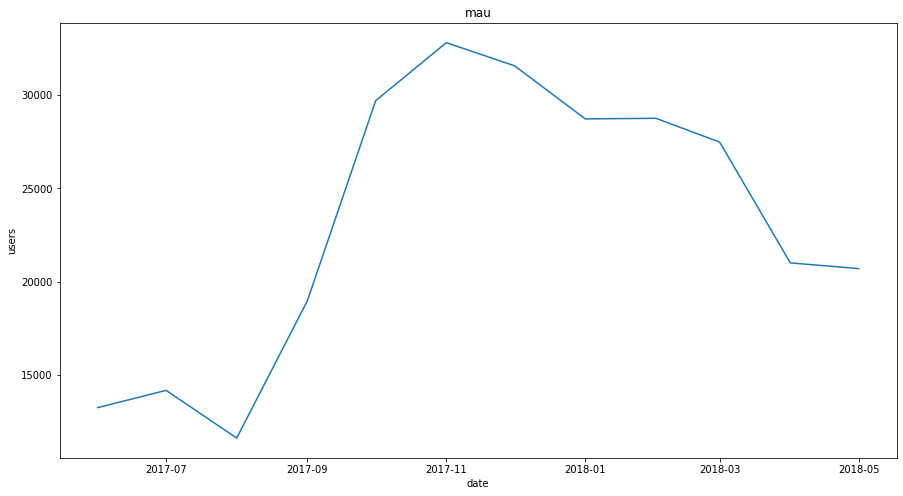

In [8]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(mau)
ax.set(title = 'mau', xlabel = 'date', ylabel = 'users')
plt.show()

*очевидный всплеск количества пользователей в декабре 2017, дальше посмотрим*

**Сколько раз в день пользователи в среднем заходят на сайт?**

In [9]:
s_per_user = visits.groupby('session_date').agg({'Uid': ['count', 'nunique']})
s_per_user.columns = ['nsessions', 'nusers']
s_per_user['s_per_user'] = s_per_user['nsessions'] / s_per_user['nusers']

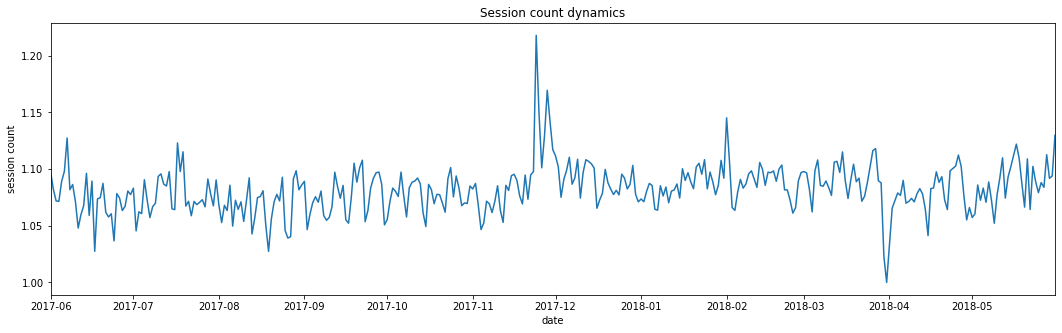

In [10]:
plt.figure(figsize= (18,5))
s_per_user['s_per_user'].plot().set(title='Session count dynamics', xlabel='date', ylabel='session count')
plt.show()

*да шо там в этом декабре происходит*

**Исследуем длительность каждой сессии**

In [11]:
visits['ses_dur_sec'] = (visits['End Ts'] - visits['Start Ts']).dt.seconds

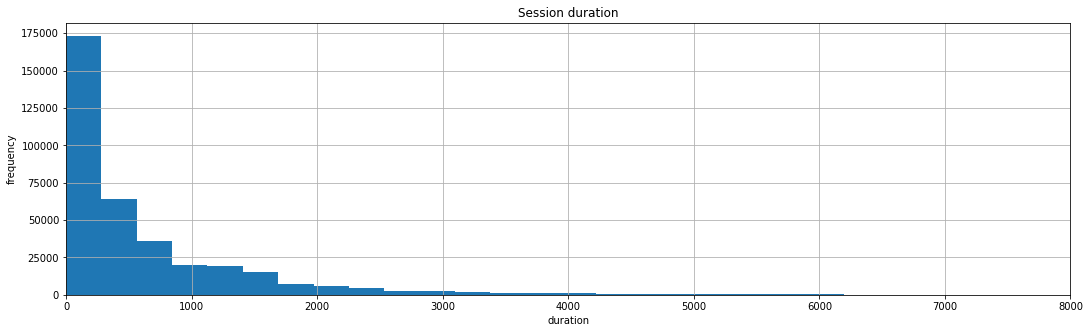

In [12]:
plt.figure(figsize=(18,5))
visits['ses_dur_sec'].hist(bins=300).set(title = 'Session duration', xlabel = 'duration', ylabel = 'frequency')
plt.xlim(0,8000)
plt.show()

*большинство сессий - короткие, есть выбросы не похожие на правду - сессии, длиной в 8 тыщ секунд, почти сутки*


**Расчет Retention Rate, когортный анализ**

определяем дату и время первой сессии для когортного анализа

In [13]:
fvisits = visits.groupby('Uid').agg({'Start Ts': 'min'}).reset_index()
fvisits.columns = ['Uid', '1session_start']


определяем первую дату и месяц визита

In [14]:
fvisits['fst_sess_date'] = fvisits['1session_start'].dt.date
fvisits['fst_sess_month'] = fvisits['1session_start'].astype('datetime64[M]')

сливаем на основании айди посетителя

In [15]:
visits_df = pd.merge(fvisits, visits, on = 'Uid')


определяем возраст когорты

In [16]:
visits_df['cohort_age'] = ((visits_df['session_month'] - visits_df['fst_sess_month']) / np.timedelta64(1,'M')).round().astype('int')

красивый когортный анализ

In [17]:
cohorts = visits_df.pivot_table(index='fst_sess_month',
                               columns='cohort_age',
                               values='Uid',
                               aggfunc='nunique')
cohorts.fillna('')


cohort_age,0,1,2,3,4,5,6,7,8,9,10,11
fst_sess_month,,,,,,,,,,,,
2017-06-01,13259.0,1043,713,814,909,947,809,766,694,674,539,596
2017-07-01,13140.0,737,674,738,765,633,596,601,510,376,361,
2017-08-01,10181.0,783,640,639,510,448,370,402,284,265,,
2017-09-01,16704.0,1428,1156,847,658,632,599,404,381,,,
2017-10-01,25977.0,2042,1357,1012,890,837,555,529,,,,
2017-11-01,27248.0,2133,1202,1054,919,638,594,,,,,
2017-12-01,25268.0,1410,960,786,512,481,,,,,,
2018-01-01,22624.0,1351,890,565,458,,,,,,,
2018-02-01,22197.0,1267,565,446,,,,,,,,


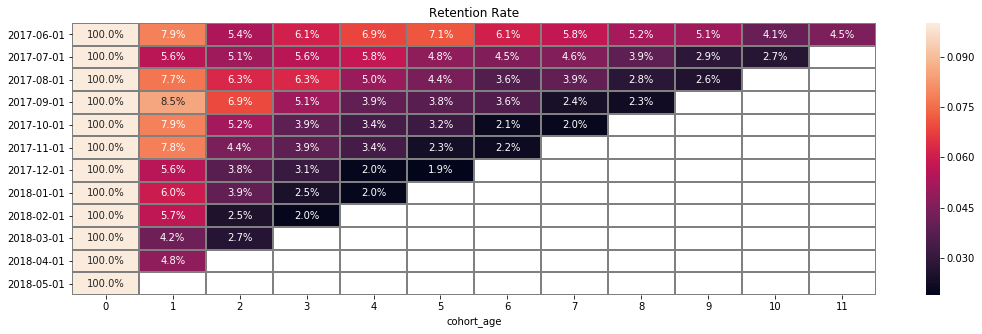

In [18]:
retention = pd.DataFrame()
for col in cohorts.columns:
    retention = pd.concat([retention, cohorts[col]/cohorts[0]], axis=1)
retention.columns = cohorts.columns
retention.index = [str(x)[0:10] for x in retention.index]
plt.figure(figsize=(18,5))
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='grey', vmax=0.1).set(title='Retention Rate')
plt.show()

In [19]:
retention.describe()

cohort_age,0,1,2,3,4,5,6,7,8,9,10,11
count,12.0,11.000000,10.000000,9.000000,8.000000,7.000000,6.000000,5.000000,4.000000,3.000000,2.000000,1.000000
mean,1.0,0.065167,0.046333,0.042760,0.040595,0.039444,0.036957,0.037509,0.035465,0.035159,0.034062,0.044951
std,0.0,0.014757,0.014307,0.015761,0.017316,0.017549,0.014992,0.015441,0.013083,0.013636,0.009318,NaN
min,1.0,0.041818,0.025454,0.020093,0.020244,0.019036,0.021365,0.020364,0.022809,0.026029,0.027473,0.044951
25%,1.0,0.055945,0.038329,0.031107,0.030361,0.027818,0.025315,0.024186,0.026624,0.027322,0.030768,0.044951
50%,1.0,0.059715,0.047704,0.038958,0.036826,0.037835,0.036101,0.039485,0.033354,0.028615,0.034062,0.044951
75%,1.0,0.078444,0.053391,0.056164,0.052125,0.046089,0.043104,0.045738,0.042195,0.039724,0.037357,0.044951
max,1.0,0.085489,0.069205,0.062764,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951


средний RR на второй месяц жизни когорт 6%

**Среднее количество уникальных пользователей в день - 907, в неделю - 5724, в месяц -  23228.
Наибольший всплеск пользователей наблюдается в ноябре-декабре.
Каждый уникальный пользователь в среднем заходит один раз и длительность сессий короткая.
Средний RR на второй месяц жизни 6%, самой "успешной" на второй месяц стала сентябрьская когорта. В целом, хорошую динамику показывают когорты июня и августа**

### Метрики электронной коммерции

**2.2.1. Среднее время между первым посещением сайта и покупкой**

In [20]:
orders['Buy Ts'] = orders['Buy Ts'].dt.date
orders['order_month'] = orders['Buy Ts'].astype('datetime64[M]')

In [21]:
#время первой покупки
first_order = orders.groupby('Uid').agg({'Buy Ts': 'min'}).reset_index()
first_order.columns = ['Uid', 'first_order_time']
#first_order['first_order_date'] = first_order['first_order_time'].dt.date
first_order['first_order_month'] = first_order['first_order_time'].astype('datetime64[M]')


In [22]:
buyers = pd.merge(fvisits, first_order, on = 'Uid')
buyers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36523 entries, 0 to 36522
Data columns (total 6 columns):
Uid                  36523 non-null uint64
1session_start       36523 non-null datetime64[ns]
fst_sess_date        36523 non-null object
fst_sess_month       36523 non-null datetime64[ns]
first_order_time     36523 non-null object
first_order_month    36523 non-null datetime64[ns]
dtypes: datetime64[ns](3), object(2), uint64(1)
memory usage: 2.0+ MB


In [23]:
#снова переводим в формат времени пару столбцов
buyers['fst_sess_date'] = pd.to_datetime(buyers['fst_sess_date'])
buyers['first_order_time'] = pd.to_datetime(buyers['first_order_time'])

In [24]:
buyers['days_1purchase'] = ((buyers['first_order_time'] - buyers['fst_sess_date']) / np.timedelta64(1, 'D')).astype('int')

In [25]:
buyers

,Uid,1session_start,fst_sess_date,fst_sess_month,first_order_time,first_order_month,days_1purchase
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03,2018-01-01,107
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-06-03,2017-06-01,0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,2017-10-01,2017-10-11,2017-10-01,0
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-01,2018-01-28,2018-01-01,1
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-24,2017-11-01,0
...,...,...,...,...,...,...,...
36518,18445147675727495770,2017-08-20 13:30:00,2017-08-20,2017-08-01,2017-11-24,2017-11-01,96
36519,18445407535914413204,2017-09-22 23:48:00,2017-09-22,2017-09-01,2017-09-22,2017-09-01,0
36520,18445601152732270159,2017-08-07 11:51:00,2017-08-07,2017-08-01,2018-03-26,2018-03-01,231
36521,18446156210226471712,2017-11-07 10:01:00,2017-11-07,2017-11-01,2018-02-18,2018-02-01,103


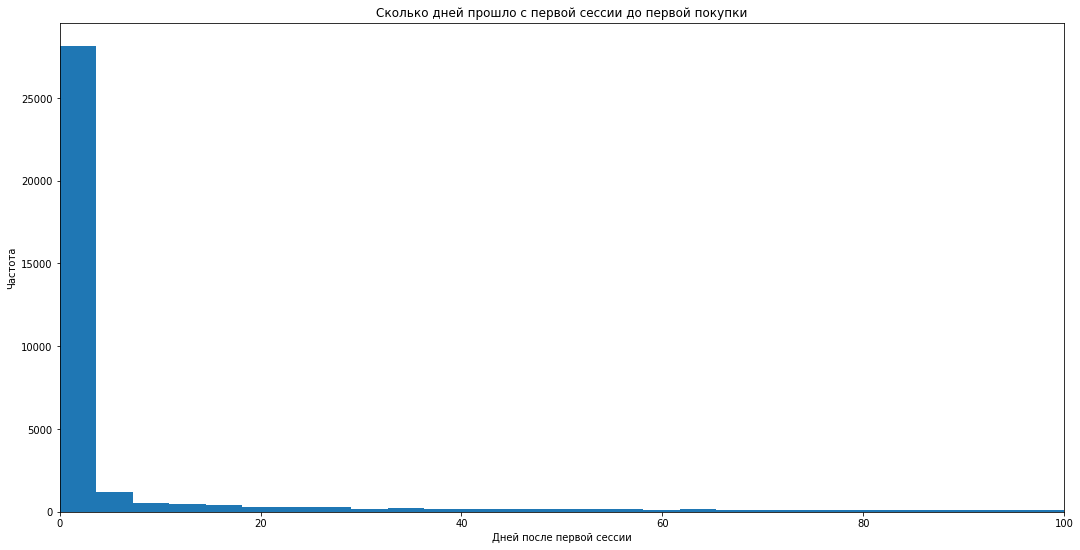

In [26]:
(buyers['days_1purchase'].plot(kind='hist', bins=100, figsize=(18,9)).set(title = 'Сколько дней прошло с первой сессии до первой покупки',
                                                                          xlabel = 'Дней после первой сессии',
                                                                          ylabel = 'Частота'))
plt.xlim(0,100)
plt.show()

**среднее количество дней между первой сессией и покупкой = 0, значит, что, в среднем, покупка совершается в тот же день первой сессии. хороший показатель работы сайта**

**2.2.2. Среднее количество покупок на 1 покупателя**

In [27]:
cohort_size = buyers.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_size.rename(columns={'Uid':'n_buyers'}, inplace=True)

cohorts1 = pd.merge(orders, buyers, how='inner', on='Uid').groupby(['first_order_month', 'order_month']).agg({'Revenue': 'count'}).reset_index()

cohorts1.head()

,first_order_month,order_month,Revenue
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292


In [28]:
#возраст когорты
cohorts1['age_month'] = ((cohorts1['order_month'] - cohorts1['first_order_month']) / np.timedelta64(1, 'M')).round()
cohorts1.columns = ['first_order_month', 'order_month', 'n_orders', 'age_month']

#количество покупок на посетителя
cohorts_report = pd.merge(cohort_size, cohorts1, on = 'first_order_month')
cohorts_report['orders_per_buyer'] = cohorts_report['n_orders'] / cohorts_report['n_buyers']

In [29]:
cohorts_report

,first_order_month,n_buyers,order_month,n_orders,age_month,orders_per_buyer
0,2017-06-01,2023,2017-06-01,2354,0.0,1.163618
1,2017-06-01,2023,2017-07-01,177,1.0,0.087494
2,2017-06-01,2023,2017-08-01,174,2.0,0.086011
3,2017-06-01,2023,2017-09-01,226,3.0,0.111715
4,2017-06-01,2023,2017-10-01,292,4.0,0.144340
...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,176,2.0,0.049816
75,2018-04-01,2276,2018-04-01,2495,0.0,1.096221
76,2018-04-01,2276,2018-05-01,195,1.0,0.085677
77,2018-05-01,2988,2018-05-01,3249,0.0,1.087349


накопительная доля покупок на 1 пользователя

In [30]:
cohorts_age = cohorts_report.pivot_table(index='first_order_month', columns='age_month', values='orders_per_buyer', aggfunc='sum').cumsum(axis=1)
cohorts_age

age_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,1.163618,1.251112,1.337123,1.448838,1.593178,1.700939,1.837370,1.923381,2.028176,2.103806,2.151261,2.193772
2017-07-01,1.136765,1.188768,1.251170,1.305252,1.342694,1.385335,1.417057,1.443058,1.473219,1.485699,1.513261,NaN
2017-08-01,1.118978,1.197810,1.270803,1.329927,1.391971,1.437226,1.472993,1.529927,1.563504,1.597080,NaN,NaN
2017-09-01,1.136381,1.221232,1.283611,1.347152,1.373111,1.415343,1.457187,1.478884,1.502518,NaN,NaN,NaN
2017-10-01,1.143779,1.216129,1.253456,1.281567,1.311290,1.335023,1.354839,1.383641,NaN,NaN,NaN,NaN
2017-11-01,1.179368,1.276648,1.321245,1.372948,1.406273,1.420730,1.445724,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.152635,1.214237,1.260324,1.301164,1.320785,1.344741,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.121554,1.187963,1.235102,1.254076,1.277201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.121611,1.182416,1.205149,1.224322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Среднее количество покупок на 1 покупателя за 6 месяцев

In [31]:
round(cohorts_age[5].mean(), 2)

1.43

**2.2.3 Средний чек**

рассчитаем средний чек по месяцам и сразу отобразим на графике

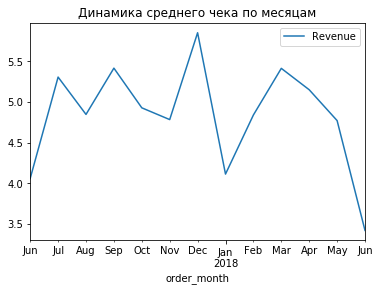

In [32]:
orders.pivot_table(index='order_month', values='Revenue', aggfunc='mean').plot().set(title='Динамика среднего чека по месяцам')
plt.show()

как и в начале с посещениями, значительно увеличивается показатель в ноябре-декабре. можно предположить, что пользователи не зря заходили на сайт:)

In [33]:
#добавим еще средний чек за весь период для сравнения, как сильно колеблется чек на графиках
round(orders['Revenue'].mean(), 2)

5.0

**2.2.4. LTV**

посчитаем выручку

In [34]:
cohorts_ltv = pd.merge(orders, buyers, how='inner', on='Uid').groupby(['first_order_month', 'order_month']).agg({'Revenue': 'sum'}).reset_index()

cohorts_ltv.head()

,first_order_month,order_month,Revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [35]:
# снова возраст когорты
cohorts_ltv['age_month'] = ((cohorts1['order_month'] - cohorts1['first_order_month']) / np.timedelta64(1, 'M')).round()
cohorts_ltv.columns = ['first_order_month', 'order_month', 'revenue', 'age_month']


In [36]:
# считаем выручку на каждого покупателя
cohorts_report_ltv = pd.merge(cohort_size, cohorts_ltv, on = 'first_order_month')
cohorts_report_ltv['revenue_per_buyer'] = cohorts_report_ltv['revenue'] / cohorts_report['n_buyers']

In [37]:
# теперь показываем накопительную выручку на покупателя
cohorts_age_ltv = cohorts_report_ltv.pivot_table(index='first_order_month', columns='age_month', values='revenue_per_buyer', aggfunc='sum').cumsum(axis=1)
cohorts_age_ltv.round(2).fillna('')

age_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


**Так же как и в таблице RR - выделяются когорты июня и сентября.
средний чек, традиционно, перед Новым годом выше,а после него - яма.
Покупки, в среднем, совершаются в первый же день посещения сайта - хороший знак. Дальше нужно будет определять источники.**

### Маркетинговые метрики

**2.3.1. Общая сумма расходов на маркетинг**

In [38]:
print('Общие расходы на маркетинг составили {}'.format(costs['costs'].sum()))

Общие расходы на маркетинг составили 329131.62


In [39]:
#добавим месяц в таблицу для распределения метрики
costs['costs_month'] = costs['dt'].astype('datetime64[M]')

In [40]:
#выведем расхожы по каждому источнику
print(costs.groupby('source_id').agg({'costs':'sum'}))

               costs
source_id           
1           20833.27
2           42806.04
3          141321.63
4           61073.60
5           51757.10
9            5517.49
10           5822.49


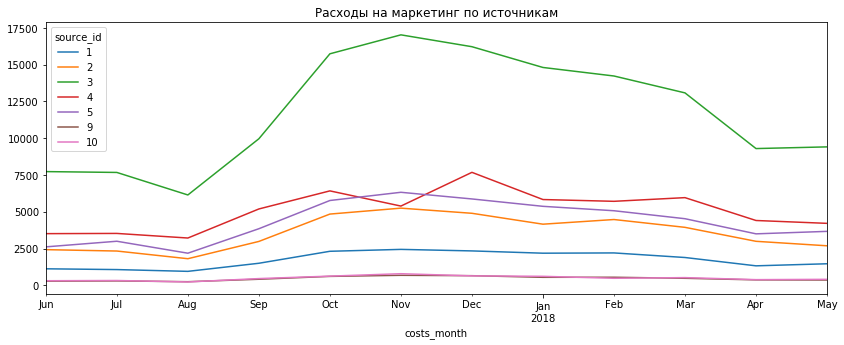

In [41]:
(costs.pivot_table(index='costs_month', columns='source_id', values='costs', aggfunc='sum').plot(figsize=(14,5), title='Расходы на маркетинг по источникам'))
plt.show()

источник под кодовым названием "3" - самый затратный в целом, 5 и 10 - самые бюджетные, а в декабре пик затрат у 4 источника

**САС**

In [42]:
#средний САС на покупателя всего
round(costs['costs'].sum() / orders['Uid'].nunique(), 2)

9.01

In [43]:
#расходы на маркетинг по месяцам
costs_source = costs.groupby(['costs_month','source_id']) \
     .agg({'costs': 'sum'}) \
     .reset_index()
costs_source.columns = ['month', 'source_id', 'costs' ]

In [44]:

costs_source


,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


In [45]:
first_order
#будем потом объединять с покупателями

,Uid,first_order_time,first_order_month
0,313578113262317,2018-01-03,2018-01-01
1,1575281904278712,2017-06-03,2017-06-01
2,2429014661409475,2017-10-11,2017-10-01
3,2464366381792757,2018-01-28,2018-01-01
4,2551852515556206,2017-11-24,2017-11-01
...,...,...,...
36518,18445147675727495770,2017-11-24,2017-11-01
36519,18445407535914413204,2017-09-22,2017-09-01
36520,18445601152732270159,2018-03-26,2018-03-01
36521,18446156210226471712,2018-02-18,2018-02-01


In [46]:
first_visits = visits.groupby(['Uid', 'Source Id']) \
   .agg({'Start Ts': 'min'}) \
   .reset_index()
#добавим данные по источнику

In [47]:
first_visits

,Uid,Source Id,Start Ts
0,11863502262781,3,2018-03-01 17:27:00
1,49537067089222,2,2018-02-06 15:55:00
2,297729379853735,3,2017-06-07 18:47:00
3,313578113262317,2,2017-09-18 22:49:00
4,325320750514679,5,2017-09-30 14:29:00
...,...,...,...
277865,18446403737806311543,5,2017-11-30 03:36:00
277866,18446424184725333426,4,2017-12-06 20:32:00
277867,18446556406699109058,3,2018-01-01 16:29:00
277868,18446621818809592527,4,2017-12-27 13:27:00


In [48]:
#первая покупка и сессия + источник
buyers_SI = pd.merge(first_order, first_visits, on='Uid', how='left')
buyers_SI

,Uid,first_order_time,first_order_month,Source Id,Start Ts
0,313578113262317,2018-01-03,2018-01-01,2,2017-09-18 22:49:00
1,1575281904278712,2017-06-03,2017-06-01,10,2017-06-03 10:13:00
2,2429014661409475,2017-10-11,2017-10-01,3,2017-10-11 17:14:00
3,2464366381792757,2018-01-28,2018-01-01,5,2018-01-27 20:10:00
4,2551852515556206,2017-11-24,2017-11-01,5,2017-11-24 10:14:00
...,...,...,...,...,...
57260,18446156210226471712,2018-02-18,2018-02-01,1,2018-02-08 15:48:00
57261,18446156210226471712,2018-02-18,2018-02-01,3,2017-11-07 10:01:00
57262,18446156210226471712,2018-02-18,2018-02-01,4,2017-11-07 12:52:00
57263,18446156210226471712,2018-02-18,2018-02-01,5,2018-02-14 21:05:00


In [49]:
#уникальные покупатели по месяцу и источнику
buyers_SI_unique = buyers_SI.groupby(['first_order_month', 'Source Id']).agg({'Uid':'nunique'}).reset_index()
buyers_SI_unique.columns = ['month', 'source_id', 'n_buyers']

In [50]:
buyers_SI_unique

,month,source_id,n_buyers
0,2017-06-01,1,401
1,2017-06-01,2,457
2,2017-06-01,3,874
3,2017-06-01,4,644
4,2017-06-01,5,571
...,...,...,...
81,2018-05-01,4,987
82,2018-05-01,5,703
83,2018-05-01,9,98
84,2018-05-01,10,164


In [51]:
#объединим ежемесячный расход на маркетинг с уникальными покупателями по источнику
cac = pd.merge(costs_source, buyers_SI_unique, on=['month', 'source_id'])
cac

,month,source_id,costs,n_buyers
0,2017-06-01,1,1125.61,401
1,2017-06-01,2,2427.38,457
2,2017-06-01,3,7731.65,874
3,2017-06-01,4,3514.80,644
4,2017-06-01,5,2616.12,571
...,...,...,...,...
79,2018-05-01,3,9411.42,1006
80,2018-05-01,4,4214.21,987
81,2018-05-01,5,3669.56,703
82,2018-05-01,9,362.17,98


In [52]:
#рассчитаем сас
cac['cac'] = (cac['costs'] / cac['n_buyers']).round(2)

In [53]:
cac

,month,source_id,costs,n_buyers,cac
0,2017-06-01,1,1125.61,401,2.81
1,2017-06-01,2,2427.38,457,5.31
2,2017-06-01,3,7731.65,874,8.85
3,2017-06-01,4,3514.80,644,5.46
4,2017-06-01,5,2616.12,571,4.58
...,...,...,...,...,...
79,2018-05-01,3,9411.42,1006,9.36
80,2018-05-01,4,4214.21,987,4.27
81,2018-05-01,5,3669.56,703,5.22
82,2018-05-01,9,362.17,98,3.70


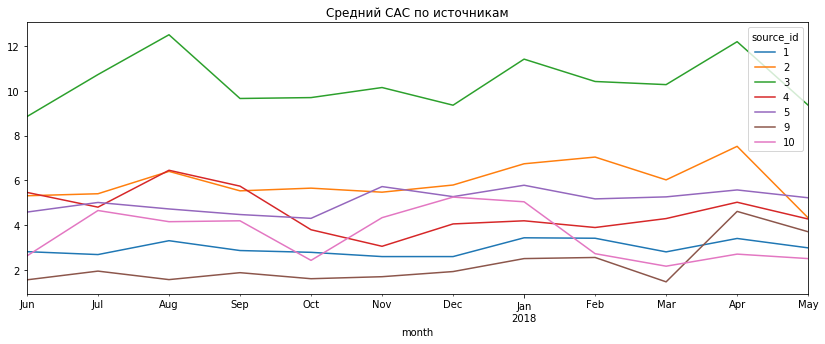

In [55]:
(cac.pivot_table(index='month', columns='source_id', values='cac', aggfunc='mean').plot(figsize=(14,5), \
title='Средний CAC по источникам'))
plt.show()

**ROMI**

Сводные таблицы расходов на маркетинг по каждому источнику, по месяцам

In [56]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid', 'session_year', 'session_month', 'session_week', 'session_date', 'ses_dur_sec']

In [57]:
users = visits.sort_values('start_ts').groupby('uid').first()

In [58]:
users

,device,end_ts,source_id,start_ts,session_year,session_month,session_week,session_date,ses_dur_sec
uid,,,,,,,,,
11863502262781,touch,2018-03-01 17:33:00,3,2018-03-01 17:27:00,2018,2018-03-01,2018-03-01,2018-03-01,360
49537067089222,touch,2018-02-06 15:57:00,2,2018-02-06 15:55:00,2018,2018-02-01,2018-02-01,2018-02-06,120
297729379853735,desktop,2017-06-07 18:48:00,3,2017-06-07 18:47:00,2017,2017-06-01,2017-06-01,2017-06-07,60
313578113262317,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,2017,2017-09-01,2017-09-14,2017-09-18,1080
325320750514679,desktop,2017-09-30 14:38:00,5,2017-09-30 14:29:00,2017,2017-09-01,2017-09-28,2017-09-30,540
...,...,...,...,...,...,...,...,...,...
18446403737806311543,desktop,2017-11-30 03:39:00,5,2017-11-30 03:36:00,2017,2017-11-01,2017-11-30,2017-11-30,180
18446424184725333426,touch,2017-12-06 20:32:00,4,2017-12-06 20:32:00,2017,2017-12-01,2017-11-30,2017-12-06,0
18446556406699109058,touch,2018-01-01 16:31:00,3,2018-01-01 16:29:00,2018,2018-01-01,2017-12-28,2018-01-01,120


In [59]:
orders.columns = ['uid', 'buy_ts', 'revenue', 'order_month']

In [62]:
users = users.merge(orders, on='uid', how='left')

In [63]:
users

,uid,device,end_ts,source_id,start_ts,session_year,session_month,session_week,session_date,ses_dur_sec,buy_ts,revenue,order_month
0,11863502262781,touch,2018-03-01 17:33:00,3,2018-03-01 17:27:00,2018,2018-03-01,2018-03-01,2018-03-01,360,NaN,NaN,NaT
1,49537067089222,touch,2018-02-06 15:57:00,2,2018-02-06 15:55:00,2018,2018-02-01,2018-02-01,2018-02-06,120,NaN,NaN,NaT
2,297729379853735,desktop,2017-06-07 18:48:00,3,2017-06-07 18:47:00,2017,2017-06-01,2017-06-01,2017-06-07,60,NaN,NaN,NaT
3,313578113262317,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,2017,2017-09-01,2017-09-14,2017-09-18,1080,NaN,NaN,NaT
4,325320750514679,desktop,2017-09-30 14:38:00,5,2017-09-30 14:29:00,2017,2017-09-01,2017-09-28,2017-09-30,540,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
228164,18446403737806311543,desktop,2017-11-30 03:39:00,5,2017-11-30 03:36:00,2017,2017-11-01,2017-11-30,2017-11-30,180,NaN,NaN,NaT
228165,18446424184725333426,touch,2017-12-06 20:32:00,4,2017-12-06 20:32:00,2017,2017-12-01,2017-11-30,2017-12-06,0,NaN,NaN,NaT
228166,18446556406699109058,touch,2018-01-01 16:31:00,3,2018-01-01 16:29:00,2018,2018-01-01,2017-12-28,2018-01-01,120,NaN,NaN,NaT
228167,18446621818809592527,desktop,2017-12-27 14:08:00,4,2017-12-27 13:27:00,2017,2017-12-01,2017-12-21,2017-12-27,2460,NaN,NaN,NaT


In [64]:
ltv1 = users.query('source_id == 1')

In [65]:
ltv1

,uid,device,end_ts,source_id,start_ts,session_year,session_month,session_week,session_date,ses_dur_sec,buy_ts,revenue,order_month
10,639163879428517,desktop,2018-03-13 14:27:00,1,2018-03-13 14:17:00,2018,2018-03-01,2018-03-08,2018-03-13,600,NaN,NaN,NaT
31,2168476032750309,desktop,2017-11-14 21:04:00,1,2017-11-14 20:53:00,2017,2017-11-01,2017-11-09,2017-11-14,660,NaN,NaN,NaT
34,2383957017622830,desktop,2017-08-25 22:02:00,1,2017-08-25 21:56:00,2017,2017-08-01,2017-08-24,2017-08-25,360,NaN,NaN,NaT
168,13866352514219281,desktop,2017-08-19 01:09:00,1,2017-08-19 01:02:00,2017,2017-08-01,2017-08-17,2017-08-19,420,NaN,NaN,NaT
180,15655711192510207,desktop,2018-02-20 14:26:00,1,2018-02-20 14:02:00,2018,2018-02-01,2018-02-15,2018-02-20,1440,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
228040,18436446293786304770,desktop,2017-11-07 18:23:00,1,2017-11-07 18:17:00,2017,2017-11-01,2017-11-02,2017-11-07,360,NaN,NaN,NaT
228044,18436650472890569350,desktop,2017-06-06 16:10:00,1,2017-06-06 16:08:00,2017,2017-06-01,2017-06-01,2017-06-06,120,NaN,NaN,NaT
228131,18444038629205408176,touch,2017-11-21 21:47:00,1,2017-11-21 21:34:00,2017,2017-11-01,2017-11-16,2017-11-21,780,NaN,NaN,NaT
228134,18444565513386044523,desktop,2017-10-02 14:00:00,1,2017-10-02 13:55:00,2017,2017-10-01,2017-09-28,2017-10-02,300,NaN,NaN,NaT
